# Microlensing Effect Example

In this notebook we look at how we can apply a simple microlensing effect that wraps the [VBMicrolensing package](https://github.com/valboz/VBMicrolensing).  

Note that the VBMicrolensing package is not installed as part of the default LightCurveLynx installation. Users will need to manually install VBMicrolensing via pip (e.g. `pip install VBMicrolensing`) in order to run this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.effects.microlensing import Microlensing
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.models.basic_models import ConstantSEDModel, SinWaveModel
from lightcurvelynx.models.lightcurve_template_model import LightcurveTemplateModel
from lightcurvelynx.utils.plotting import plot_lightcurves


# Usually we would not hardcode the path to the passband files, but for this demo we will use a relative path
# to the test data directory so that we do not have to download the files.
data_dir = Path("../../../tests/lightcurvelynx/data")

## Basic Application

In the most basic form, the microlensing effect can be added to any model (`BasePhysicalModel`). Here we start with a constant SED model with no microlensing.

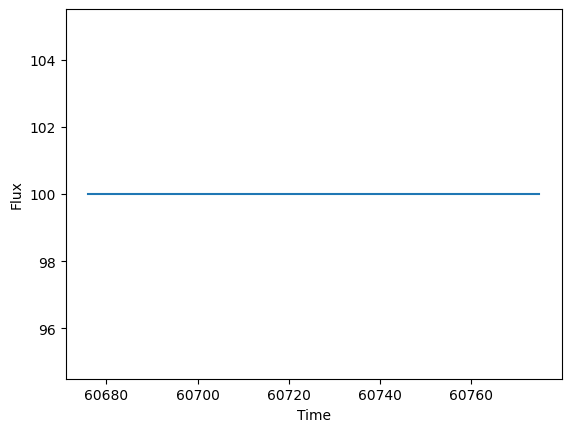

In [2]:
source = ConstantSEDModel(brightness=100.0)

t_start = 60676.0
times = np.arange(100.0) + t_start
wavelengths = np.array([7000.0])
fluxes = source.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

Now we add a microlensing effect.  As you can see, the microlensing introduces a magnification 20.0 days after the start of the light curve.

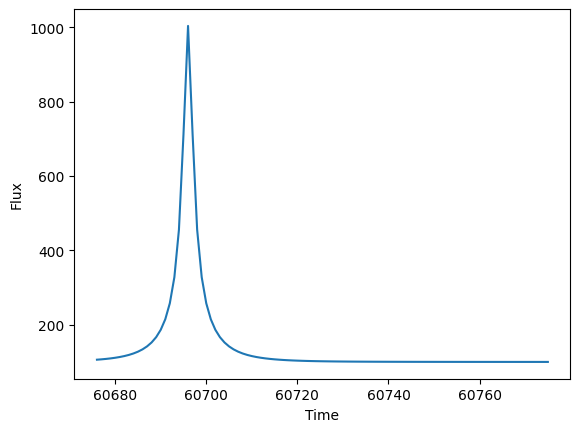

In [3]:
ml_effect = Microlensing(microlensing_t0=t_start + 20.0, u_0=0.1, t_E=10.0)
source.add_effect(ml_effect)

fluxes = source.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

The model underneath the microlense does not need to be constant. We could simulate a small amount of variability by using a sin wave based model.

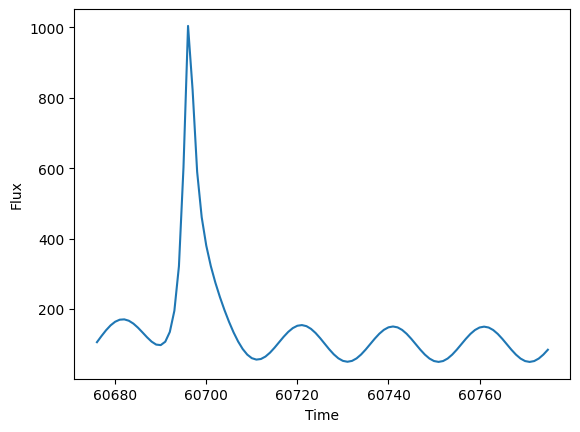

In [4]:
source2 = SinWaveModel(brightness=100.0, amplitude=50.0, frequency=0.05, t0=t_start)
source2.add_effect(ml_effect)
fluxes = source2.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## More Complex Models

We can extend the microlensing effect with any one of our SED or bandflux based models. For example consider a `LightcurveModel` which takes sample data points in each bandflux and returns the interpolated values.

We start by loading passbands, which are needed from the light curve model. Here we use (potentially older) data from the test directory to avoid needing to do a download. Users will generally want to download the most recent passbands. See the passbands notebook for more details.

In [12]:
# Load the passband data for the griz filters only.
filters = ["g", "r", "i", "z"]
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters=filters,
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=data_dir / "passbands",
)

2025-09-04 11:29:43,204 - INFO - Loading passbands from preset LSST
2025-09-04 11:29:43,207 - INFO - Downloading data file from https://github.com/lsst/throughputs/blob/main/baseline/total_u.dat?raw=true to ../../tests/lightcurvelynx/data/passbands/LSST/u.dat
SHA256 hash of downloaded file: d8fb220fed913551eb1ae5744a49e145d62aa2fd97786b515f30d20e13223b37
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
2025-09-04 11:29:43,689 - INFO - Loading passband from file: ../../tests/lightcurvelynx/data/passbands/LSST/u.dat
2025-09-04 11:29:43,700 - INFO - Downloading data file from https://github.com/lsst/throughputs/blob/main/baseline/total_g.dat?raw=true to ../../tests/lightcurvelynx/data/passbands/LSST/g.dat
SHA256 hash of downloaded file: f8935b3a5514e436aea45895369f568bfcc57a682852b0abe3292fd754a7094f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't c

Next we define a series of light curves to use as our background model.  These will be defined for the griz filters.

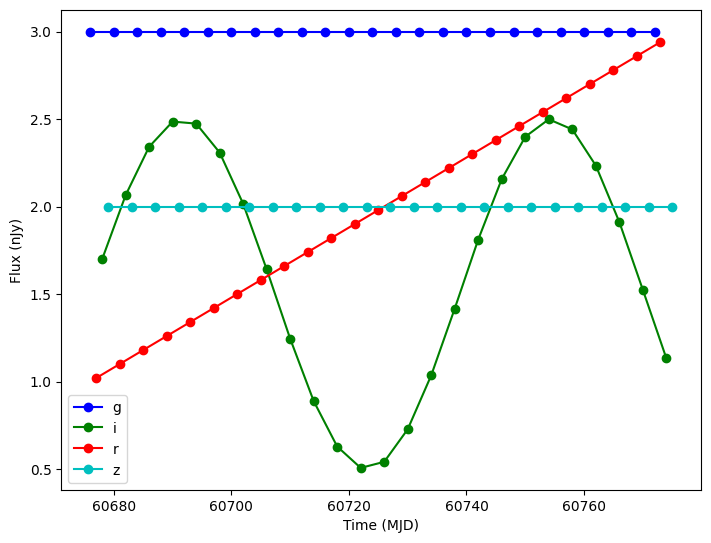

In [6]:
dts = np.arange(100.0)
times = dts + t_start

lightcurves = {
    "g": np.array([times, 3.0 * np.ones_like(times)]).T,  # Constant at 3.0
    "r": np.array([times, 0.02 * dts + 1.0]).T,  # Slight linear increase
    "i": np.array([times, np.sin(dts / 10.0) + 1.5]).T,  # Sin wave
    "z": np.array([times, 2.0 * np.ones_like(times)]).T,  # Constant at 2.0
}

lc_source = LightcurveTemplateModel(lightcurves, passband_group, t0=0)
graph_state = lc_source.sample_parameters(num_samples=1)

query_filters = np.array([filters[i % 4] for i in range(len(times))])
fluxes = lc_source.evaluate_bandfluxes(passband_group, times, query_filters, graph_state)

plot_lightcurves(fluxes, times, fluxerrs=None, filters=query_filters)

We can add microlensing to this model as we would any other model.

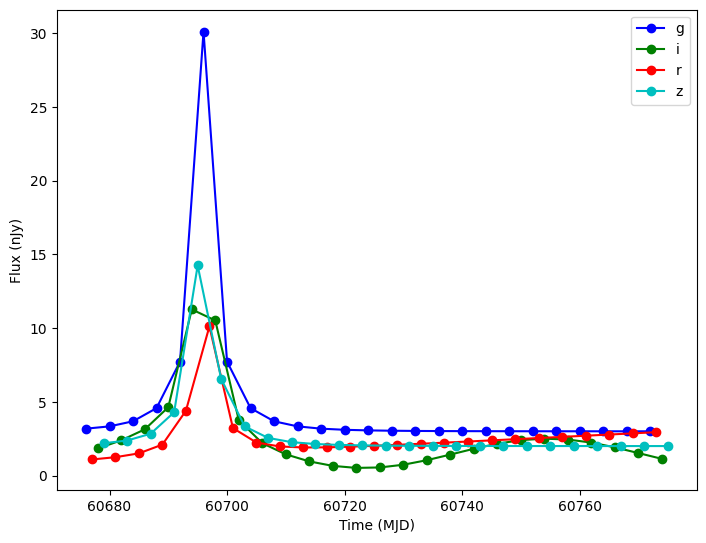

In [7]:
lc_source.add_effect(ml_effect)

# We need to resample to include the effect’s parameters.
graph_state = lc_source.sample_parameters(num_samples=1)
fluxes = lc_source.evaluate_bandfluxes(passband_group, times, query_filters, graph_state)

plot_lightcurves(fluxes, times, fluxerrs=None, filters=query_filters)

## Varying the Microlensing Parameters

The main parameters of the microlensing model (`microlensing_t0`, `u_0`, and `t_E`) can be set like any other sample-able parameter. For example, let’s draw the start time uniformly from [60686.0, 60700.0], `u_0` from a normal centered on 0.1, and `t_E` from a normal centered on 20.0. We can then draw 10 samples and see how they vary.

In [8]:
source = ConstantSEDModel(brightness=100.0, node_label="source")

ml_effect = Microlensing(
    microlensing_t0=NumpyRandomFunc("uniform", low=60686.0, high=60700.0),
    u_0=NumpyRandomFunc("normal", loc=0.1, scale=0.01),
    t_E=NumpyRandomFunc("normal", loc=20.0, scale=3.0),
)
source.add_effect(ml_effect)

state = source.sample_parameters(num_samples=5)

print("T0:", state["source"]["microlensing_t0"])
print("u_0:", state["source"]["u_0"])
print("t_E:", state["source"]["t_E"])

T0: [60696.11972119 60692.65231996 60695.32034458 60698.5158131
 60691.42642555]
u_0: [0.11704899 0.09859567 0.10320024 0.06966052 0.09489545]
t_E: [20.18035427 18.24375444 22.05895847 17.51510998 22.28195792]


And we can plot the first few curves.  Notice how the timing and shape of the lensing event varies.

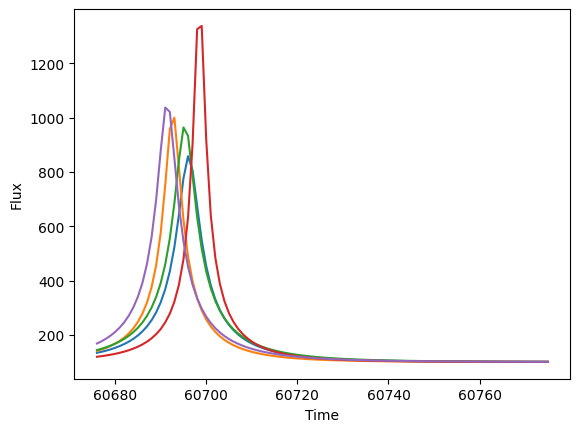

In [9]:
fluxes = source.evaluate_sed(times, wavelengths, graph_state=state)

for i in range(5):
    plt.plot(times, fluxes[i, :, 0])
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## Probabilistically Applying Microlensing

The microlensing effect also includes the ability to probabilistically apply the effect to only a subset of the light curves. This is useful if you want a random 1 in every 10,000 stars to be microlensed.  The probability is controlled via the `probability` parameter.

In the below example, only 50% of the samples will have the microlensing applied. The samples with microlensing are shown in red and the samples without it are shown in blue. 

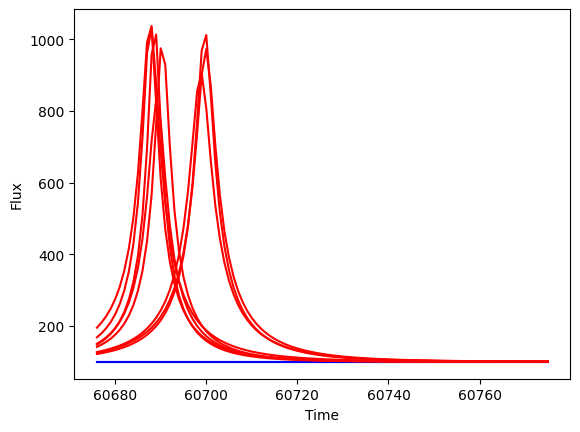

In [10]:
source = ConstantSEDModel(brightness=100.0, node_label="source")

ml_effect = Microlensing(
    microlensing_t0=NumpyRandomFunc("uniform", low=60686.0, high=60700.0),
    u_0=NumpyRandomFunc("normal", loc=0.1, scale=0.01),
    t_E=NumpyRandomFunc("normal", loc=20.0, scale=3.0),
    probability=0.5,
)
source.add_effect(ml_effect)

state = source.sample_parameters(num_samples=10)
fluxes = source.evaluate_sed(times, wavelengths, graph_state=state)
for i in range(10):
    if state["source"]["apply_microlensing"][i]:
        plt.plot(times, fluxes[i, :, 0], color="red")
    else:
        plt.plot(times, fluxes[i, :, 0], color="blue")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## Blended Models

For a more realistic simulation, let us consider the combination of two different sources of flux:

  * **Source** - The source that is being microlensed. This flux will be magnified by the lense.
  * **Blends** - The flux coming from the background (or maybe the lense itself)

The structure of this model is shown in the following illustration:

![An example sampling graph](../../_static/MicrolensingGraph.png "Sampling Graph")

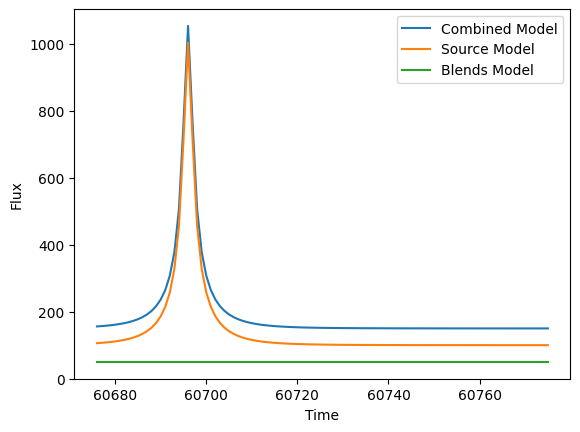

In [11]:
from lightcurvelynx.models.multi_object_model import AdditiveMultiObjectModel

# Create the blends.
blends = ConstantSEDModel(brightness=50.0, node_label="blends")

# Create the model and add the lensing effect.
source = ConstantSEDModel(brightness=100.0, node_label="source")
ml_effect = Microlensing(microlensing_t0=t_start + 20.0, u_0=0.1, t_E=10.0)
source.add_effect(ml_effect)

# The full model is the sum of all three flux sources.
model = AdditiveMultiObjectModel([source, blends])

# Evaluate the combined model at different times.
fluxes_all = model.evaluate_sed(times, wavelengths)
fluxes_source = source.evaluate_sed(times, wavelengths)
fluxes_blends = blends.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes_all, label="Combined Model")
plt.plot(times, fluxes_source, label="Source Model")
plt.plot(times, fluxes_blends, label="Blends Model")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

As we can see from the graph, in this example, the microlensing magnification was only applied to the source model (not the blends model).